In [269]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import pandasql as pdsql
import matplotlib.pyplot as plt
import sys
import math

In [270]:
LIGA = "premier"
BOOKIE_ODDS_OVER_COL = "B365>2.5"
BOOKIE_ODDS_UNDER_COL = "B365<2.5"

df_matches = pd.read_csv("Datasets/" + LIGA + "/matches_with_ratings.csv")

df_matches.tail(10)

,HomeTeam,AwayTeam,FTHG,FTAG,HST,AST,HC,AC,B365>2.5,B365<2.5,Season,P>2.5,P<2.5,RATING_H_DEF,RATING_H_OFF,RATING_A_DEF,RATING_A_OFF
1679,Tottenham,Newcastle,4,1,12,3,3,6,1.53,2.40,2023-24,0.641944,0.358056,10.851439,13.608914,11.029111,14.955181
1680,Nott'm Forest,Tottenham,0,2,1,6,6,4,1.62,2.25,2023-24,0.600213,0.399787,10.209794,3.003984,10.343811,4.758689
1681,Chelsea,Sheffield United,2,0,6,1,7,6,1.50,2.50,2023-24,0.646498,0.353502,11.298971,11.820222,9.977641,11.245663
1682,Man City,Crystal Palace,2,2,9,2,6,1,1.44,2.70,2023-24,0.670801,0.329199,4.627479,18.356430,4.152241,14.748996
1683,Newcastle,Fulham,3,0,10,4,5,1,1.70,2.10,2023-24,0.571955,0.428045,8.033234,11.512527,6.766098,11.096377
1684,Burnley,Everton,0,2,2,6,8,6,2.05,1.75,2023-24,0.473480,0.526520,12.514054,8.356135,12.713707,9.684645
1685,Arsenal,Brighton,2,0,9,1,10,1,1.53,2.40,2023-24,0.640856,0.359144,0.000000,20.390663,0.000000,16.288636
1686,Brentford,Aston Villa,1,2,3,5,7,12,1.70,2.10,2023-24,0.566479,0.433521,11.038109,7.835094,10.695569,8.623554
1687,West Ham,Wolves,3,0,4,3,6,6,1.95,1.95,2023-24,0.495200,0.504800,11.367824,7.665823,11.271773,9.269756
1688,Liverpool,Man United,0,0,8,1,12,0,1.33,3.40,2023-24,0.734327,0.265673,5.548971,18.652967,6.193774,17.392825


In [271]:
INITIAL_BANKROLL = 100
BANKROLL_HISTORY = [INITIAL_BANKROLL]
MATCHES_TO_SIMULATE = 1000
BET_SIZE = 10

df_sample = df_matches.tail(380)
sum_ev = 0

for index, row in df_sample.iterrows():
    if 1 / row[BOOKIE_ODDS_OVER_COL] < row["P>2.5"]:
        sum_ev += row["P>2.5"] * row[BOOKIE_ODDS_OVER_COL] - 1
        if (row["FTHG"] + row["FTAG"]) > 2:
            BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] + row[BOOKIE_ODDS_OVER_COL] * BET_SIZE)
        else:
            BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] - BET_SIZE)
    elif 1 / row[BOOKIE_ODDS_UNDER_COL] < row["P<2.5"]:
        sum_ev += row["P<2.5"] * row[BOOKIE_ODDS_UNDER_COL] - 1
        if (row["FTHG"] + row["FTAG"]) < 3:
            BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] + row[BOOKIE_ODDS_UNDER_COL] * BET_SIZE)
        else:
            BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] - BET_SIZE)

print("EV: " + str(sum_ev))
print("final bankroll: " + str(BANKROLL_HISTORY[-1]))

EV: 0.10394558355526762
final bankroll: 219.39999999999998


C:\Users\sauce\AppData\Local\Temp\ipykernel_31180\1910153708.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample.loc[index, "BET_UNDER"] = 1
C:\Users\sauce\AppData\Local\Temp\ipykernel_31180\1910153708.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample.loc[index, "BET_OVER"] = 1


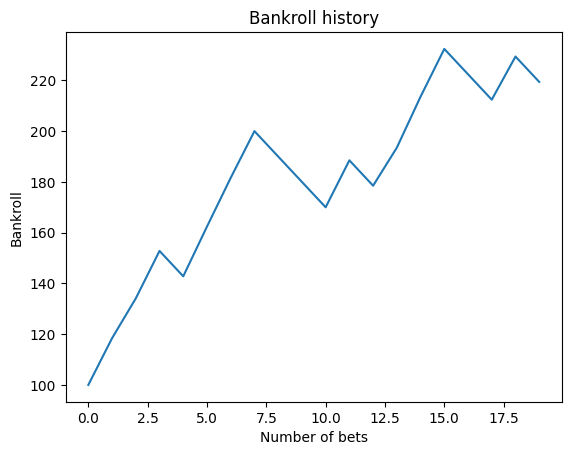

In [272]:
# Visualize bankroll history elegantly
plt.plot(BANKROLL_HISTORY)
plt.xlabel("Number of bets")
plt.ylabel("Bankroll")
plt.title("Bankroll history")
plt.show()